# Imports

In [42]:
pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [43]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
# from skimage import io,transform,img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import math
import time
from datetime import datetime
import shutil
import tensorboard
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
from PIL import Image, ImageDraw, ImageFont
import torchvision.utils as vutils
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import confusion_matrix
import itertools
import torch.distributed as dist
import torch.multiprocessing as mp
from sklearn.model_selection import train_test_split

# Dataset and dataloaders

In [44]:
class ZooplanktonDataset(Dataset):
    def __init__(self, csv, cropped_image_folder, transform=None):
        self.annotations = pd.read_csv(csv)
        self.cropped_image_folder = cropped_image_folder
        self.transform = transform
        self.labels = np.array(self.annotations.iloc[:, 1])
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        cropped_img_path = os.path.join(self.cropped_image_folder, img_name)
        
        image = Image.open(cropped_img_path).convert('RGB')
        
        y_label = self.annotations.iloc[index, 1]
            
        if self.transform:
            image = self.transform(image)
        
        return image, y_label


# Oversampling

In [45]:
# from torchvision.transforms import RandomRotation, RandomAffine

# class ZooplanktonDataset(Dataset):
#     def __init__(self, csv, cropped_image_folder, transform=None):
#         self.annotations = pd.read_csv(csv)
#         self.cropped_image_folder = cropped_image_folder
#         self.transform = transform
        
#         # Perform oversampling
#         label_counts = self.annotations['Label'].value_counts()
#         max_count = label_counts.max()
#         self.annotations = self.oversample_minority_class(self.annotations, max_count)
    
#     def oversample_minority_class(self, annotations, target_count):
#         # Separate samples from each class
#         class_0 = annotations[annotations['Label'] == 0]
#         class_1 = annotations[annotations['Label'] == 1]

#         # Determine the number of samples to generate for the minority class
#         minority_count = target_count - len(class_1)

#         # Upsample minority class with augmentation
#         class_1_augmented = self.augment_data(class_1, minority_count)

#         # Concatenate the augmented minority class with the majority class
#         oversampled_annotations = pd.concat([class_0, class_1_augmented])

#         return oversampled_annotations
    
#     def augment_data(self, data, target_count):
#         augmented_data = []
#         rotation_angle = 30  # Specify the rotation angle
        
#         # Apply augmentation to reach the target count
#         while len(augmented_data) < target_count:
#             # Randomly select an image from the data
#             image_row = data.sample(n=1)
#             image_name = image_row['ImageName'].values[0]
#             image_path = os.path.join(self.cropped_image_folder, image_name)
            
#             # Load the image
#             image = Image.open(image_path).convert('RGB')
            
#             # Generate a new image name based on the original image name
#             augmented_image_name = image_name
            
#             # Apply additional transformations (rotation and shear)
#             rotation_transform = RandomRotation(rotation_angle)
#             affine_transform = RandomAffine(degrees=0, shear=20)
            
#             augmented_image = affine_transform(rotation_transform(image))
            
#             augmented_data.append((augmented_image, augmented_image_name, image_row['Label'].values[0]))
        
#         augmented_data_df = pd.DataFrame(augmented_data, columns=['AugmentedImage', 'ImageName', 'Label'])
#         return augmented_data_df
    
#     def __len__(self):
#         return len(self.annotations)
    
#     def __getitem__(self, index):
#         img_name = str(self.annotations.iloc[index]['ImageName'])
#         cropped_img_path = os.path.join(self.cropped_image_folder, img_name)
#         image = Image.open(cropped_img_path).convert('RGB')
#         label = self.annotations.iloc[index, 1]

#         if self.transform is not None:
#             image = self.transform(image)

#         return image, label


# Under-Sampling

In [46]:
# from sklearn.utils import resample

# class ZooplanktonDataset(Dataset):
#     def __init__(self, csv, cropped_image_folder, transform=None):
#         self.annotations = pd.read_csv(csv)
#         self.cropped_image_folder = cropped_image_folder
#         self.transform = transform
        
#         # Perform undersampling
#         label_counts = self.annotations['Label'].value_counts()
#         min_count = label_counts.min()
#         self.annotations = self.undersample_majority_class(self.annotations, min_count)
    
#     def undersample_majority_class(self, annotations, target_count):
#         # Separate samples from each class
#         class_0 = annotations[annotations['Label'] == 0]
#         class_1 = annotations[annotations['Label'] == 1]
        
#         # Downsample majority class
#         class_0_undersampled = resample(class_0, replace=False, n_samples=target_count, random_state=42)
        
#         # Concatenate the undersampled majority class with the minority class
#         undersampled_annotations = pd.concat([class_0_undersampled, class_1])
        
#         return undersampled_annotations
    
#     def __len__(self):
#         return len(self.annotations)
    
#     def __getitem__(self, index):
#         img_name = self.annotations.iloc[index, 0]
#         cropped_img_path = os.path.join(self.cropped_image_folder, img_name)
        
#         image = Image.open(cropped_img_path).convert('RGB')
        
#         label = self.annotations.iloc[index, 1]
            
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label


# Train and Test split 

In [47]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# data_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

dataset = ZooplanktonDataset(csv='/home/ec2-user/SageMaker/All_csv_combined/annotations.csv',cropped_image_folder='dataset/uncropped',
                            transform=data_transform)

from torch.utils.data import Subset

# Splitting the indices into train and test sets with a stratified split
train_indices, test_indices = train_test_split(
    np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels
)

# Create subset datasets using the train and test indices
train_set = Subset(dataset, train_indices)
test_set = Subset(dataset, test_indices)

train_loader = DataLoader(dataset=train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=16, shuffle=True)


# Models

In [48]:
class Basemodel(nn.Module):
    def __init__(self):
        super(Basemodel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32*53*53, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x

In [49]:
class Model_v1(nn.Module):
    def __init__(self):
        super(Model_v1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 26 * 26, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 64 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x


In [50]:
# class Model_v2(nn.Module):
#     def __init__(self, dropout):
#         super(Model_v2, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3)
#         self.conv2 = nn.Conv2d(16, 32, 3)
#         self.conv3 = nn.Conv2d(32, 64, 3)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.pool2 = nn.MaxPool2d(3, 2)
#         self.pool3 = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(dropout)
#         self.fc1 = nn.Linear(64 * 26 * 26, 256)
#         self.fc2 = nn.Linear(256, 84)
#         self.fc3 = nn.Linear(84, 2)
#         self.softmax = nn.LogSoftmax(dim=1)
        
#     def forward(self, x):
#         x = self.dropout(F.relu(self.conv1(x)))
#         x = self.pool1(x)
#         x = self.dropout(F.relu(self.conv2(x)))
#         x = self.pool2(x)
#         x = self.dropout(F.relu(self.conv3(x)))
#         x = self.pool3(x)
#         x = x.view(-1, 64 * 26 * 26)
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = self.softmax(self.fc3(x))
#         return x

In [51]:
# accepts 256x256
import torch.nn as nn
import torch.nn.functional as F

class Model_v2(nn.Module):
    def __init__(self, dropout):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adjusting the fully connected layers to fit the spatial dimensions
        # of the input image (256x256)
        self.fc1 = nn.Linear(64 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x


In [52]:
# import torch.nn as nn

# class Model_v2(nn.Module):
#     def __init__(self, dropout):
#         super(Model_v2, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.relu3 = nn.ReLU()
#         self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

#         self.fc1 = nn.Linear(128 * 37 * 37, 512)  # Calculate the input size based on 300x300 input images
#         self.relu4 = nn.ReLU()
#         self.dropout = nn.Dropout(dropout)  # Use the provided dropout value
#         self.fc2 = nn.Linear(512, 2)  # Output layer with 2 neurons for binary classification

#         self.softmax = nn.LogSoftmax(dim=1)

#     def forward(self, x):
#         x = self.pool1(self.relu1(self.conv1(x)))
#         x = self.pool2(self.relu2(self.conv2(x)))
#         x = self.pool3(self.relu3(self.conv3(x)))

#         x = x.view(-1, 128 * 37 * 37)  # Flatten the tensor
#         x = self.dropout(self.relu4(self.fc1(x)))
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x


In [53]:
# import torch.nn as nn
# import torch.nn.functional as F

# class Model_v2(nn.Module):
#     def __init__(self, dropout):
#         super(Model_v2, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3)
#         self.conv2 = nn.Conv2d(16, 32, 3)
#         self.conv3 = nn.Conv2d(32, 64, 3)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.pool2 = nn.MaxPool2d(3, 2)
#         self.pool3 = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(dropout)
        
#         # Adjusting the fully connected layers to fit the spatial dimensions
#         # of the input image (256x256)
#         self.fc1 = nn.Linear(64 * 30 * 30, 256)
#         self.fc2 = nn.Linear(256, 84)
#         self.fc3 = nn.Linear(84, 1)  # One output unit for binary classification
        
#     def forward(self, x):
#         x = self.dropout(F.relu(self.conv1(x)))
#         x = self.pool1(x)
#         x = self.dropout(F.relu(self.conv2(x)))
#         x = self.pool2(x)
#         x = self.dropout(F.relu(self.conv3(x)))
#         x = self.pool3(x)
#         x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = self.fc3(x) 
#         return x


In [54]:
class Model_v3(nn.Module):
    def __init__(self, dropout):
        super(Model_v3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout(F.relu(self.conv4(x)))
        x = self.pool4(x)
        x = x.view(-1, 128 * 12 * 12)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.softmax(self.fc3(x))
        return x


# Loss curve 

In [55]:
class LossCurve:
    def __init__(self):
        self

    def PlotCurve(loss_values,epochs):
        plt.plot(range(epochs), loss_values, 'blue')
        plt.title('Loss decay')
        plt.xlabel('number of epochs')
        plt.ylabel('Loss')
        plt.show()

# Training Loop

In [56]:
class Trainer():
    def __init__(self, model, loss_criterion,
                 train_data_loader, test_data_loader,
                 optimizer, epochs, with_cuda,
                 use_scheduler, scheduler, save_dir,tensorboard_dir, lr=0.001,print_freq=1):
        self.device = torch.device("cuda:0" if with_cuda else "cpu")
        self.model = model
        self.loss_criterion = loss_criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.with_cuda = with_cuda
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader
        self.lr = lr
        self.save_dir = save_dir
        self.tensorboard_dir = tensorboard_dir
        self.use_scheduler = use_scheduler
        self.scheduler = scheduler
        self.step = 0
        self.print_freq = print_freq
        self.start_time = datetime.now().strftime('%b-%d_%H-%M')
        self.save_freq = 1
        self.accuracy = 0
        if not os.path.exists(self.tensorboard_dir):
            os.makedirs(self.tensorboard_dir)
        self.writer = SummaryWriter(log_dir=self.tensorboard_dir)
        
    def _train_epoch(self):
        loss_values = []
        
        for epoch in range(self.epochs):
            running_loss = 0
            last_step = self.step - 1
            last_time = time.time()
            batch_counter = 0
            accuracy=0
            loop = tqdm(enumerate(self.train_data_loader), total=len(self.train_data_loader), leave=True)
            for batch_idx, (images, labels) in loop:
                if self.with_cuda:
                    images, labels = images.to(self.device), labels.to (self.device)
                self.model.train()
                batch_counter += 1
                # forward pass
                outputs = self.model(images)
                # finding loss
                loss = self.loss_criterion(outputs, labels)
                # backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if self.use_scheduler:
                    self.scheduler.step()

                running_loss += loss.item()
                # evaluation of model on test data
                if batch_counter % 1000 == 0 or batch_counter == len(self.train_data_loader):
                    accuracy = self._valid_epoch(self.model, epoch, self.test_data_loader)
                
                is_best = False
                if accuracy > self.accuracy:
                    is_best = True
                self.accuracy = accuracy
                
                if self.step % self.print_freq == self.print_freq - 1:
                    used_time = time.time() - last_time
                    step_num = self.step - last_step
                    speed = self.train_data_loader.batch_size * \
                        step_num / used_time
                    batch_loss = loss.item()
                    loop.set_description(f"Epoch[{epoch + 1}/{self.epochs}]")
                    loop.set_postfix(
                    lr=self.scheduler.get_last_lr(),
                    batch_loss=batch_loss,
                    global_loss = running_loss,
                    speed=speed,
                    accuracy = self.accuracy,
                    device = self.device
                    )
                    global_loss = 0.0
                    last_step = self.step
                    last_time = time.time()
                self.step += 1

            if epoch % self.save_freq == 0:
                self._save_checkpoint(epoch, is_best)
            
            self.writer.add_scalar('Loss', running_loss / len(self.train_data_loader), global_step=self.step)
            loss_values.append(running_loss / len(self.train_data_loader))
        
        print("Train Accuracy:", self._valid_epoch(self.model, self.epochs, self.train_data_loader))
        print("Validation Accuracy:", self._valid_epoch(self.model, self.epochs, self.test_data_loader))
        # Plotting Loss Curve
        LossCurve.PlotCurve(loss_values, self.epochs)
        
        #logging images to Tensorboard
        self.log_images_after_training()
        
        #closing SummaryWriter Object
        self.writer.close()
        
    def _valid_epoch(self, model, epoch, test_loader):
        model.eval()
        with torch.no_grad():
            correct_samples = 0
            total_samples = 0
            for images, labels in test_loader:
                if self.with_cuda:
                    images, labels = images.to(self.device), labels.to (self.device)
                pred_ratio = model(images)
                _, pred_labels = torch.max(pred_ratio, 1)
                total_samples += labels.size(0)
                correct_samples += (pred_labels == labels).sum().item()
            accuracy = (correct_samples / total_samples) * 100
            self.writer.add_scalar('Accuracy', accuracy, global_step=epoch)
            return accuracy
    
    def _save_checkpoint(self, epoch, is_best):
        arch = type(self.model).__name__
        state = {
            'epoch': epoch,
            'arch': arch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'accuracy': self.accuracy,
            'step': self.step + 1,
            'start_time': self.start_time}
        filename = os.path.join(
            self.save_dir+
            'checkpoint_{}_epoch{:02d}_acc_{:.5f}.pth.tar'.format(
                arch,
                epoch, 
                self.accuracy))
        print("Saving checkpoint: {} ...".format(filename))
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(
                filename, os.path.join(self.save_dir,'{}_best.pth.tar'.format(arch)))
        return filename

    def log_images_after_training(self):
        arch = type(self.model).__name__
        checkpoint = torch.load('/home/ec2-user/SageMaker/checkpoints/uncropped/{}_best.pth.tar'.format(arch))
        self.model.load_state_dict(checkpoint['state_dict'])
        self.model.eval()
        images = []
        true_labels = []
        predicted_labels = []

        for batch_images, batch_labels in self.test_data_loader:
            with torch.no_grad():
                if self.with_cuda:
                    batch_images, batch_labels = batch_images.to(self.device), batch_labels.to(self.device)

                # Forward pass to obtain predicted labels for each item in the batch
                batch_outputs = self.model(batch_images)
                batch_predicted_labels = torch.argmax(batch_outputs, dim=1)
            # Iterate over each item in the batch
            for i in range(batch_images.size(0)):
                image = vutils.make_grid(batch_images[i], nrow=1, padding=10, normalize=True) 
                true_label = batch_labels[i]
                predicted_label = batch_predicted_labels[i]

                images.append(image)
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)

        for i in range(len(images)):
            image = images[i]
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]

            # Set the image name as the predicted and true labels
            image_name = f"Image-{i}-True-{true_label}-Predicted-{predicted_label}"

            # Log the image on TensorBoard with the image name
            self.writer.add_image(image_name, image.cpu(), global_step=i)

        #creating confusion matrix
        true_labels = torch.tensor(true_labels)
        predicted_labels = torch.tensor(predicted_labels)

        cm = confusion_matrix(true_labels, predicted_labels)

        fig = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()

        # Set the axis labels and ticks
        class_names = ['Zooplankton', 'Marine-Snow']
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)

        # Add labels to each cell of the confusion matrix
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        # Save the confusion matrix figure to TensorBoard
        self.writer.add_figure('Confusion Matrix', fig)



In [57]:
# import os
# import time
# import shutil
# import torch
# import torch.nn as nn
# import torchvision.utils as vutils
# from datetime import datetime
# from tqdm import tqdm
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import numpy as np
# import itertools
# from torch.utils.tensorboard import SummaryWriter


# class Trainer():
#     def __init__(self, model, loss_criterion, threshold,
#                  train_data_loader, test_data_loader,
#                  optimizer, epochs, with_cuda,
#                  use_scheduler, scheduler, save_dir, tensorboard_dir, lr=0.001, print_freq=1):
#         self.device = torch.device("cuda:0" if with_cuda else "cpu")
#         self.model = model
#         self.loss_criterion = loss_criterion
#         self.optimizer = optimizer
#         self.epochs = epochs
#         self.with_cuda = with_cuda
#         self.train_data_loader = train_data_loader
#         self.test_data_loader = test_data_loader
#         self.lr = lr
#         self.save_dir = save_dir
#         self.tensorboard_dir = tensorboard_dir
#         self.use_scheduler = use_scheduler
#         self.scheduler = scheduler
#         self.step = 0
#         self.print_freq = print_freq
#         self.start_time = datetime.now().strftime('%b-%d_%H-%M')
#         self.save_freq = 1
#         self.accuracy = 0
#         if not os.path.exists(self.tensorboard_dir):
#             os.makedirs(self.tensorboard_dir)
#         self.writer = SummaryWriter(log_dir=self.tensorboard_dir)
#         self.threshold = threshold  # Threshold for classifying as true or false (0 to 1)

#     def _train_epoch(self):
#         loss_values = []

#         for epoch in range(self.epochs):
#             running_loss = 0
#             last_step = self.step - 1
#             last_time = time.time()
#             batch_counter = 0
#             accuracy = 0
#             loop = tqdm(enumerate(self.train_data_loader), total=len(self.train_data_loader), leave=True)
#             for batch_idx, (images, labels) in loop:
#                 if self.with_cuda:
#                     images, labels = images.to(self.device), labels.to(self.device)
#                 self.model.train()
#                 batch_counter += 1
#                 labels = labels.view(-1, 1).float()
#                 # forward pass
#                 outputs = self.model(images)
#                 # finding loss
#                 loss = self.loss_criterion(outputs, labels)
#                 # backward pass
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()

#                 if self.use_scheduler:
#                     self.scheduler.step()

#                 running_loss += loss.item()
#                 # evaluation of model on test data
#                 if batch_counter % 1000 == 0 or batch_counter == len(self.train_data_loader):
#                     accuracy = self._valid_epoch(self.model, epoch, self.test_data_loader)

#                 is_best = False
#                 if accuracy > self.accuracy:
#                     is_best = True
#                 self.accuracy = accuracy

#                 if self.step % self.print_freq == self.print_freq - 1:
#                     used_time = time.time() - last_time
#                     step_num = self.step - last_step
#                     speed = self.train_data_loader.batch_size * step_num / used_time
#                     batch_loss = loss.item()
#                     loop.set_description(f"Epoch[{epoch + 1}/{self.epochs}]")
#                     loop.set_postfix(
#                         lr=self.scheduler.get_last_lr(),
#                         batch_loss=batch_loss,
#                         global_loss=running_loss,
#                         speed=speed,
#                         accuracy=self.accuracy,
#                         device=self.device
#                     )
#                     global_loss = 0.0
#                     last_step = self.step
#                     last_time = time.time()
#                 self.step += 1

#             if epoch % self.save_freq == 0:
#                 self._save_checkpoint(epoch, is_best)

#             self.writer.add_scalar('Loss', running_loss / len(self.train_data_loader), global_step=self.step)
#             loss_values.append(running_loss / len(self.train_data_loader))

#         print("Train Accuracy:", self._valid_epoch(self.model, self.epochs, self.train_data_loader))
#         print("Validation Accuracy:", self._valid_epoch(self.model, self.epochs, self.test_data_loader))
#         # Plotting Loss Curve
#         LossCurve.PlotCurve(loss_values, self.epochs)

#         # logging images to Tensorboard
#         self.log_images_after_training()

#         # closing SummaryWriter Object
#         self.writer.close()

#     def _valid_epoch(self, model, epoch, test_loader):
#         model.eval()
#         with torch.no_grad():
#             correct_samples = 0
#             total_samples = 0
#             for images, labels in test_loader:
#                 if self.with_cuda:
#                     images, labels = images.to(self.device), labels.to(self.device)
#                 pred_ratio = model(images)
#                 pred_labels = (pred_ratio > self.threshold).float()  # Applying the threshold
#                 total_samples += labels.size(0)
#                 correct_samples += (pred_labels == labels).sum().item()
#             accuracy = (correct_samples / total_samples) * 100
#             self.writer.add_scalar('Accuracy', accuracy, global_step=epoch)
#             return accuracy

#     def _save_checkpoint(self, epoch, is_best):
#         arch = type(self.model).__name__
#         state = {
#             'epoch': epoch,
#             'arch': arch,
#             'state_dict': self.model.state_dict(),
#             'optimizer': self.optimizer.state_dict(),
#             'accuracy': self.accuracy,
#             'step': self.step + 1,
#             'start_time': self.start_time}
#         filename = os.path.join(
#             self.save_dir +
#             'checkpoint_{}_epoch{:02d}_acc_{:.5f}.pth.tar'.format(
#                 arch,
#                 epoch,
#                 self.accuracy))
#         print("Saving checkpoint: {} ...".format(filename))
#         if not os.path.exists(self.save_dir):
#             os.makedirs(self.save_dir)
#         torch.save(state, filename)
#         if is_best:
#             shutil.copyfile(
#                 filename, os.path.join(self.save_dir, '{}_best.pth.tar'.format(arch)))
#         return filename

#     def log_images_after_training(self):
#         arch = type(self.model).__name__
#         checkpoint = torch.load('/home/ec2-user/SageMaker/checkpoints/uncropped/{}_best.pth.tar'.format(arch))
#         self.model.load_state_dict(checkpoint['state_dict'])
#         self.model.eval()
#         images = []
#         true_labels = []
#         predicted_labels = []

#         for batch_images, batch_labels in self.test_data_loader:
#             with torch.no_grad():
#                 if self.with_cuda:
#                     batch_images, batch_labels = batch_images.to(self.device), batch_labels.to(self.device)

#                 # Forward pass to obtain predicted labels for each item in the batch
#                 batch_outputs = self.model(batch_images)
#                 batch_predicted_labels = (batch_outputs > self.threshold).float()  # Applying the threshold

#             # Iterate over each item in the batch
#             for i in range(batch_images.size(0)):
#                 image = vutils.make_grid(batch_images[i], nrow=1, padding=10, normalize=True)
#                 true_label = batch_labels[i]
#                 predicted_label = batch_predicted_labels[i]

#                 images.append(image)
#                 true_labels.append(true_label)
#                 predicted_labels.append(predicted_label)

#         for i in range(len(images)):
#             image = images[i]
#             true_label = true_labels[i]
#             predicted_label = predicted_labels[i]

#             # Set the image name as the predicted and true labels
#             image_name = f"Image-{i}-True-{true_label}-Predicted-{predicted_label}"

#             # Log the image on TensorBoard with the image name
#             self.writer.add_image(image_name, image.cpu(), global_step=i)

#         # creating confusion matrix
#         true_labels = torch.tensor(true_labels)
#         predicted_labels = torch.tensor(predicted_labels)

#         cm = confusion_matrix(true_labels, predicted_labels)

#         fig = plt.figure(figsize=(8, 8))
#         plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#         plt.colorbar()

#         # Set the axis labels and ticks
#         class_names = ['Zooplankton', 'Marine-Snow']
#         tick_marks = np.arange(len(class_names))
#         plt.xticks(tick_marks, class_names)
#         plt.yticks(tick_marks, class_names)

#         # Add labels to each cell of the confusion matrix
#         thresh = cm.max() / 2.
#         for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#             plt.text(j, i, format(cm[i, j], 'd'),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")

#         # Save the confusion matrix figure to TensorBoard
#         self.writer.add_figure('Confusion Matrix', fig)


# Hyperparameters

In [58]:
    #model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Model_v2(0.2)
    model.to(device)
    parameters = filter(lambda p: p.requires_grad, model.parameters())
   # optimizer 
    optimizer = optim.RAdam(
        params=parameters,
        lr=0.001,
        betas=(0.8, 0.999),
        eps=1e-8,
        weight_decay=1e-7)
    #scheduler
    lr_warm_up_num = 100
    cr = 1.0 / math.log(lr_warm_up_num)
    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda ee: cr * math.log(ee + 1)
        if ee < lr_warm_up_num else 1)
    #  loss, metrics
    data = pd.read_csv('/home/ec2-user/SageMaker/All_csv_combined/annotations.csv')
    label_counts = data.iloc[:, 1].value_counts()
    loss_ratio = label_counts[0] / label_counts[1]
    weight = torch.Tensor([1.0, loss_ratio]).to(device)
    print(weight)
    loss_criterion = torch.nn.CrossEntropyLoss(weight=weight)
    #creating object for tensorboard_dir
    tensorboard_dir = '/home/ec2-user/SageMaker/runs/'


tensor([1.0000, 6.3882], device='cuda:0')


# Trainer Object

In [59]:
   trainer = Trainer(
        model, loss_criterion,
        train_data_loader=train_loader,
        test_data_loader=test_loader,
        optimizer=optimizer,
        epochs=30,
        with_cuda=True,
        use_scheduler=True,
        scheduler=scheduler,
        save_dir='/home/ec2-user/SageMaker/checkpoints/uncropped/',
        tensorboard_dir=tensorboard_dir,
        lr=0.01)
 

# Hyperparameter Search

In [60]:
# import itertools

# # Define the hyperparameter grid
# hyperparameter_grid = {
#     'model': [Model_v2,Model_v3], # adding more layers # adding more maxpool and make 
#     'lr': [0.001], # imp
#     'weight_decay': [1e-3,1e-4,1e-5,1e-7],
#     'dropout': [0.2], #imp
#     'loss_weight': [1.0],
#     'batch_size': [16], # most imp
#     'lr_warm_up_num':[100]
# }

# # Create a list of all possible combinations of hyperparameters
# hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

# # Define a function for training and evaluating the model with a given set of hyperparameters
# def train_and_evaluate_model(model_class, lr, weight_decay, dropout, loss_weight, batch_size, lr_warm_up_num):
#     # Create the model
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model = model_class(dropout)
#     model.to(device)
#     parameters = filter(lambda p: p.requires_grad, model.parameters())
    
#     # Create the optimizer
#     optimizer = optim.Adam(
#         params=parameters,
#         lr=lr,
#         betas=(0.8, 0.999),
#         eps=1e-8,
#         weight_decay=weight_decay)
#     tensorboard_dir = '/home/ec2-user/SageMaker/runs/'
#     # Create the scheduler
#     lr_warm_up_num = lr_warm_up_num
#     cr = 1.0 / math.log(lr_warm_up_num)
#     scheduler = optim.lr_scheduler.LambdaLR(
#         optimizer,
#         lr_lambda=lambda ee: cr * math.log(ee + 1)
#         if ee < lr_warm_up_num else 1)
    
#     # Create the loss criterion
#     data = pd.read_csv('dataset/uncropped/annotations.csv')
#     label_counts = data.iloc[:, 1].value_counts()
#     loss_ratio = label_counts[0] / label_counts[1]
#     weight = torch.Tensor([1,loss_ratio]).to(device)
#     loss_criterion = torch.nn.CrossEntropyLoss(weight=weight)
    
# #     # Load the data with the specified batch size
# #     dataset_length = len(dataset)
# #     train_size = int(0.7 * dataset_length)
# #     test_size = dataset_length - train_size
# #     train_set, test_set = torch.utils.data.random_split(dataset, [train_size,test_size])

# #     train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
# #     test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
    
#     # Splitting the indices into train and test sets with a stratified split
#     train_indices, test_indices = train_test_split(
#         np.arange(len(dataset)), test_size=0.2, stratify=dataset.labels
#     )

#     # Create subset datasets using the train and test indices
#     train_set = Subset(dataset, train_indices)
#     test_set = Subset(dataset, test_indices)

#     train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
    
#     # Create the Trainer object
#     trainer = Trainer(
#         model, loss_criterion,
#         train_data_loader=train_loader,
#         test_data_loader=test_loader,
#         optimizer=optimizer,
#         epochs=30,
#         with_cuda=True,
#         use_scheduler=True,
#         scheduler=scheduler,
#         save_dir='/home/ec2-user/SageMaker/checkpoints/uncropped/',
#         tensorboard_dir=tensorboard_dir,
#         lr=lr)
    
#     # Train the model
#     trainer._train_epoch()
    
#     # Evaluate the model
#     accuracy = trainer._valid_epoch(model, 0, test_loader)
    
#     return accuracy

# # Perform grid search
# best_accuracy = 0.0
# best_hyperparameters = None

# for hyperparameters in hyperparameter_combinations:
#     model_class, lr, weight_decay, dropout, loss_weight, batch_size, lr_warm_up_num = hyperparameters
#     print(f"Training model {model_class.__name__} with lr={lr}, weight_decay={weight_decay}, dropout={dropout}, loss_weight={loss_weight}, batch_size={batch_size}, lr_warm_up_num={lr_warm_up_num}...")
#     accuracy = train_and_evaluate_model(model_class, lr, weight_decay, dropout, loss_weight, batch_size, lr_warm_up_num)
    
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_hyperparameters = hyperparameters
        
# print(best_accuracy)
# print(best_hyperparameters)


# 10-fold cross validation

In [61]:
# import itertools
# from sklearn.model_selection import KFold

# # Define the hyperparameter grid showing best hyperparameters obtained from Hyperparameter search Grid
# hyperparameter_grid = {
#     'model': [Model_v2],
#     'lr': [0.001],
#     'weight_decay': [1e-7],
#     'dropout': [0.2],
#     'loss_weight': [1.0],
#     'batch_size': [16]
# }

# # Create a list of all possible combinations of hyperparameters
# hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

# def train_and_evaluate_model(model_class, lr, weight_decay, dropout, loss_weight, batch_size, train_loader, test_loader):
#     # Create the model
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model = model_class(dropout)
#     model.to(device)
#     parameters = filter(lambda p: p.requires_grad, model.parameters())
    
#     # Create the optimizer
#     optimizer = optim.Adam(
#         params=parameters,
#         lr=lr,
#         betas=(0.8, 0.999),
#         eps=1e-8,
#         weight_decay=weight_decay)
#     tensorboard_dir = '/home/ec2-user/SageMaker/runs/'
#     # Create the scheduler
#     lr_warm_up_num = 100
#     cr = 1.0 / math.log(lr_warm_up_num)
#     scheduler = optim.lr_scheduler.LambdaLR(
#         optimizer,
#         lr_lambda=lambda ee: cr * math.log(ee + 1)
#         if ee < lr_warm_up_num else 1)
    
#     # Create the loss criterion
#     data = pd.read_csv('dataset/uncropped/annotations.csv')
#     label_counts = data.iloc[:, 1].value_counts()
#     loss_ratio = label_counts[0] / label_counts[1]
#     weight = torch.Tensor([1,loss_ratio]).to(device)
#     loss_criterion = torch.nn.CrossEntropyLoss(weight=weight)
    
#     # Create the Trainer object
#     trainer = Trainer(
#         model, loss_criterion,
#         train_data_loader=train_loader,
#         test_data_loader=test_loader,
#         optimizer=optimizer,
#         epochs=30,
#         with_cuda=True,
#         use_scheduler=True,
#         scheduler=scheduler,
#         save_dir='/home/ec2-user/SageMaker/checkpoints/uncropped/',
#         tensorboard_dir=tensorboard_dir,
#         lr=lr)
    
#     # Train the model
#     trainer._train_epoch()
    
#     # Evaluate the model
#     accuracy = trainer._valid_epoch(model, 0, test_loader)
    
#     return accuracy

# # Perform 10-fold cross-validation
# num_folds = 10
# kf = KFold(n_splits=num_folds)

# hyperparameter_accuracies = {}

# data = pd.read_csv('dataset/uncropped/annotations.csv')
# label_counts = data.iloc[:, 1].value_counts()
# minority_class_label = label_counts.idxmin()
# print(minority_class_label)

# for hyperparameters in hyperparameter_combinations:
#     model_class, lr, weight_decay, dropout, loss_weight, batch_size = hyperparameters
#     print(f"Training model {model_class.__name__} with lr={lr}, weight_decay={weight_decay}, dropout={dropout}, loss_weight={loss_weight}, batch_size={batch_size}...")
    
#     fold_accuracies = []
#     for train_index, test_index in kf.split(dataset.annotations):
#     # Split the indices into training and testing sets for the current fold
#         train_indices = train_index
#         test_indices = test_index

#         # Select the minority class instances from the test indices
#         test_indices_minority = test_indices[data.iloc[test_indices, 1] == minority_class_label]
#         test_indices_majority = test_indices[data.iloc[test_indices, 1] != minority_class_label]

#         # Calculate the desired number of minority class instances per fold
#         num_minority_per_fold = len(test_indices_minority) // num_folds

#         # Randomly sample the desired number of minority class instances for the current fold
#         test_indices_minority_sampled = np.random.choice(test_indices_minority, size=num_minority_per_fold, replace=False)

#         # Combine the sampled minority class instances with the majority class instances
#         test_indices_balanced = np.concatenate((test_indices_majority, test_indices_minority_sampled))

#         # Shuffle the test indices to ensure randomization
#         np.random.shuffle(test_indices_balanced)

#         # Create subset datasets using the train and balanced test indices
#         train_set = Subset(dataset, train_indices)
#         test_set = Subset(dataset, test_indices_balanced)

#         # Create data loaders for the current fold
#         train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
#         test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

#         # Train and evaluate the model for the current fold
#         accuracy = train_and_evaluate_model(model_class, lr, weight_decay, dropout, loss_weight, batch_size, train_loader, test_loader)
#         fold_accuracies.append(accuracy)


#     average_accuracy = sum(fold_accuracies) / num_folds
#     print(f"Average accuracy across {num_folds} folds: {average_accuracy}%")
    
#     hyperparameter_accuracies[hyperparameters] = average_accuracy

# # Print the accuracies for each hyperparameter combination
# for hyperparameters, accuracy in hyperparameter_accuracies.items():
#     print(f"Hyperparameters: {hyperparameters}")
#     print(f"Average accuracy: {accuracy}%")


# Final Training

Epoch[1/30]: 100%|██████████| 800/800 [01:23<00:00,  9.54it/s, accuracy=86.7, batch_loss=0.715, device=cuda:0, global_loss=552, lr=[0.001], speed=1.12]            


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch00_acc_86.74171.pth.tar ...


Epoch[2/30]: 100%|██████████| 800/800 [01:20<00:00,  9.99it/s, accuracy=85.6, batch_loss=0.547, device=cuda:0, global_loss=522, lr=[0.001], speed=1.36]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch01_acc_85.64728.pth.tar ...


Epoch[3/30]: 100%|██████████| 800/800 [01:17<00:00, 10.28it/s, accuracy=80.1, batch_loss=0.787, device=cuda:0, global_loss=509, lr=[0.001], speed=1.4]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch02_acc_80.11257.pth.tar ...


Epoch[4/30]: 100%|██████████| 800/800 [01:26<00:00,  9.29it/s, accuracy=79.5, batch_loss=0.784, device=cuda:0, global_loss=499, lr=[0.001], speed=1.3]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch03_acc_79.45591.pth.tar ...


Epoch[5/30]: 100%|██████████| 800/800 [01:21<00:00,  9.87it/s, accuracy=81.8, batch_loss=0.417, device=cuda:0, global_loss=477, lr=[0.001], speed=1.3]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch04_acc_81.83240.pth.tar ...


Epoch[6/30]: 100%|██████████| 800/800 [01:21<00:00,  9.77it/s, accuracy=82.2, batch_loss=0.785, device=cuda:0, global_loss=448, lr=[0.001], speed=1.3]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch05_acc_82.23890.pth.tar ...


Epoch[7/30]: 100%|██████████| 800/800 [01:19<00:00, 10.02it/s, accuracy=83.1, batch_loss=0.295, device=cuda:0, global_loss=407, lr=[0.001], speed=1.31]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch06_acc_83.05191.pth.tar ...


Epoch[8/30]: 100%|██████████| 800/800 [01:23<00:00,  9.63it/s, accuracy=80.8, batch_loss=0.353, device=cuda:0, global_loss=357, lr=[0.001], speed=1.32]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch07_acc_80.83177.pth.tar ...


Epoch[9/30]: 100%|██████████| 800/800 [01:20<00:00,  9.89it/s, accuracy=86.1, batch_loss=0.179, device=cuda:0, global_loss=307, lr=[0.001], speed=1.34]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch08_acc_86.14759.pth.tar ...


Epoch[10/30]: 100%|██████████| 800/800 [01:21<00:00,  9.87it/s, accuracy=84.2, batch_loss=0.723, device=cuda:0, global_loss=285, lr=[0.001], speed=1.35]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch09_acc_84.24015.pth.tar ...


Epoch[11/30]: 100%|██████████| 800/800 [01:20<00:00,  9.96it/s, accuracy=82.7, batch_loss=0.351, device=cuda:0, global_loss=246, lr=[0.001], speed=1.4]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch10_acc_82.67667.pth.tar ...


Epoch[12/30]: 100%|██████████| 800/800 [01:21<00:00,  9.79it/s, accuracy=81.4, batch_loss=0.0644, device=cuda:0, global_loss=226, lr=[0.001], speed=1.34]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch11_acc_81.42589.pth.tar ...


Epoch[13/30]: 100%|██████████| 800/800 [01:21<00:00,  9.84it/s, accuracy=85.8, batch_loss=0.071, device=cuda:0, global_loss=205, lr=[0.001], speed=1.34]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch12_acc_85.83490.pth.tar ...


Epoch[14/30]: 100%|██████████| 800/800 [01:23<00:00,  9.56it/s, accuracy=84.1, batch_loss=0.0803, device=cuda:0, global_loss=203, lr=[0.001], speed=1.33]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch13_acc_84.11507.pth.tar ...


Epoch[15/30]: 100%|██████████| 800/800 [01:21<00:00,  9.82it/s, accuracy=84.2, batch_loss=0.0868, device=cuda:0, global_loss=195, lr=[0.001], speed=1.34]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch14_acc_84.17761.pth.tar ...


Epoch[16/30]: 100%|██████████| 800/800 [01:23<00:00,  9.55it/s, accuracy=84.4, batch_loss=0.0271, device=cuda:0, global_loss=167, lr=[0.001], speed=1.3]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch15_acc_84.42777.pth.tar ...


Epoch[17/30]: 100%|██████████| 800/800 [01:22<00:00,  9.71it/s, accuracy=85.3, batch_loss=0.0758, device=cuda:0, global_loss=155, lr=[0.001], speed=1.23]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch16_acc_85.33458.pth.tar ...


Epoch[18/30]: 100%|██████████| 800/800 [01:29<00:00,  8.90it/s, accuracy=85.6, batch_loss=0.0762, device=cuda:0, global_loss=144, lr=[0.001], speed=1.08]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch17_acc_85.58474.pth.tar ...


Epoch[19/30]: 100%|██████████| 800/800 [01:24<00:00,  9.43it/s, accuracy=85.5, batch_loss=0.0565, device=cuda:0, global_loss=138, lr=[0.001], speed=1.33]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch18_acc_85.52220.pth.tar ...


Epoch[20/30]: 100%|██████████| 800/800 [01:22<00:00,  9.66it/s, accuracy=86.1, batch_loss=0.313, device=cuda:0, global_loss=121, lr=[0.001], speed=1.26]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch19_acc_86.11632.pth.tar ...


Epoch[21/30]: 100%|██████████| 800/800 [01:21<00:00,  9.77it/s, accuracy=83.8, batch_loss=0.143, device=cuda:0, global_loss=116, lr=[0.001], speed=1.37]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch20_acc_83.80238.pth.tar ...


Epoch[22/30]: 100%|██████████| 800/800 [01:20<00:00, 10.00it/s, accuracy=83.6, batch_loss=0.109, device=cuda:0, global_loss=118, lr=[0.001], speed=1.37]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch21_acc_83.55222.pth.tar ...


Epoch[23/30]: 100%|██████████| 800/800 [01:44<00:00,  7.66it/s, accuracy=85.3, batch_loss=0.0856, device=cuda:0, global_loss=104, lr=[0.001], speed=0.968]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch22_acc_85.33458.pth.tar ...


Epoch[24/30]: 100%|██████████| 800/800 [01:24<00:00,  9.48it/s, accuracy=84.9, batch_loss=0.0134, device=cuda:0, global_loss=97.4, lr=[0.001], speed=1.27]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch23_acc_84.89681.pth.tar ...


Epoch[25/30]: 100%|██████████| 800/800 [01:27<00:00,  9.12it/s, accuracy=84.8, batch_loss=0.00415, device=cuda:0, global_loss=96.4, lr=[0.001], speed=1.36]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch24_acc_84.77173.pth.tar ...


Epoch[26/30]: 100%|██████████| 800/800 [01:25<00:00,  9.35it/s, accuracy=85.6, batch_loss=0.0159, device=cuda:0, global_loss=83.5, lr=[0.001], speed=1.25]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch25_acc_85.64728.pth.tar ...


Epoch[27/30]: 100%|██████████| 800/800 [01:23<00:00,  9.54it/s, accuracy=84.2, batch_loss=0.092, device=cuda:0, global_loss=80.7, lr=[0.001], speed=1.35]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch26_acc_84.24015.pth.tar ...


Epoch[28/30]: 100%|██████████| 800/800 [01:15<00:00, 10.66it/s, accuracy=84.7, batch_loss=0.0233, device=cuda:0, global_loss=75.6, lr=[0.001], speed=1.5]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch27_acc_84.74046.pth.tar ...


Epoch[29/30]: 100%|██████████| 800/800 [01:11<00:00, 11.17it/s, accuracy=85.4, batch_loss=0.00856, device=cuda:0, global_loss=84.4, lr=[0.001], speed=1.53]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch28_acc_85.39712.pth.tar ...


Epoch[30/30]: 100%|██████████| 800/800 [01:00<00:00, 13.20it/s, accuracy=85.9, batch_loss=0.416, device=cuda:0, global_loss=97.1, lr=[0.001], speed=1.89]


Saving checkpoint: /home/ec2-user/SageMaker/checkpoints/uncropped/checkpoint_Model_v2_epoch29_acc_85.92871.pth.tar ...
Train Accuracy: 99.70289288506646
Validation Accuracy: 85.92870544090057


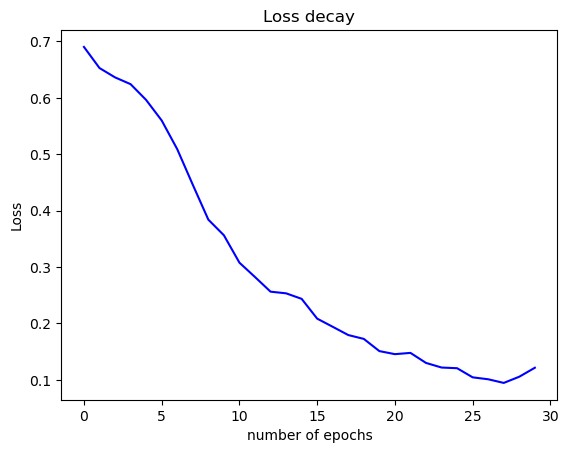

In [ ]:
trainer._train_epoch()

In [ ]:
# import itertools

# # Define the hyperparameter grid
# hyperparameter_grid = {
#     'model': [Model_v2], # adding more layers # adding more maxpool and make 
#     'lr': [0.001], # imp
#     'weight_decay': [1e-7],
#     'dropout': [0.2], #imp
#     'loss_weight': [0.3,0.5,1.0,1.5,2.0,5.0],
#     'batch_size': [16] # most imp
# }

# # Create a list of all possible combinations of hyperparameters
# hyperparameter_combinations = list(itertools.product(*hyperparameter_grid.values()))

# # Define a function for training and evaluating the model with a given set of hyperparameters
# def train_and_evaluate_model(model_class, lr, weight_decay, dropout, loss_weight, batch_size):
#     # Create the model
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model = model_class(dropout)
#     model.to(device)
#     parameters = filter(lambda p: p.requires_grad, model.parameters())
    
#     # Create the optimizer
#     optimizer = optim.Adam(
#         params=parameters,
#         lr=lr,
#         betas=(0.8, 0.999),
#         eps=1e-8,
#         weight_decay=weight_decay)
#     tensorboard_dir = '/home/ec2-user/SageMaker/runs/'
#     # Create the scheduler
#     lr_warm_up_num = 100
#     cr = 1.0 / math.log(lr_warm_up_num)
#     scheduler = optim.lr_scheduler.LambdaLR(
#         optimizer,
#         lr_lambda=lambda ee: cr * math.log(ee + 1)
#         if ee < lr_warm_up_num else 1)
    
#     # Create the loss criterion
#     data = pd.read_csv('dataset/uncropped/annotations.csv')
#     label_counts = data.iloc[:, 1].value_counts()
#     loss_ratio = label_counts[0] / label_counts[1]
#     weight = torch.Tensor([1,loss_ratio*loss_weight]).to(device)
#     loss_criterion = torch.nn.CrossEntropyLoss(weight=weight)
    
#     # Load the data with the specified batch size
#     dataset_length = len(dataset)
#     train_size = int(0.7 * dataset_length)
#     test_size = dataset_length - train_size
#     train_set, test_set = torch.utils.data.random_split(dataset, [train_size,test_size])

#     train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
#     test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)
    
#     # Create the Trainer object
#     trainer = Trainer(
#         model, loss_criterion,
#         train_data_loader=train_loader,
#         test_data_loader=test_loader,
#         optimizer=optimizer,
#         epochs=30,
#         with_cuda=True,
#         use_scheduler=True,
#         scheduler=scheduler,
#         save_dir='/home/ec2-user/SageMaker/checkpoints/uncropped/',
#         tensorboard_dir=tensorboard_dir,
#         lr=lr)
    
#     # Train the model
#     trainer._train_epoch()
    
#     # Evaluate the model
#     accuracy = trainer._valid_epoch(model, 0, test_loader)
    
#     return accuracy

# # Perform grid search
# best_accuracy = 0.0
# best_hyperparameters = None

# for hyperparameters in hyperparameter_combinations:
#     model_class, lr, weight_decay, dropout, loss_weight, batch_size = hyperparameters
#     print(f"Training model {model_class.__name__} with lr={lr}, weight_decay={weight_decay}, dropout={dropout}, loss_weight={loss_weight}, batch_size={batch_size}...")
#     accuracy = train_and_evaluate_model(model_class, lr, weight_decay, dropout, loss_weight, batch_size)
#     print(f"Accuracy: {accuracy}%")
    
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_hyperparameters = hyperparameters
        
# print(best_accuracy)
# print(best_hyperparameters)
